In [13]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_recall_curve, auc,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
#import warnings
#warnings.filterwarnings('ignore')
import os

In [2]:
data_path = os.path.dirname(os.getcwd())

In [3]:
data = pd.read_csv(data_path+'/Data/Class imbalance/creditcard.csv')
#data.Class.replace(["'0'","'1'"],[0,1],inplace=True)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

In [5]:
data['Class'].value_counts() #Label counts

0    284315
1       492
Name: Class, dtype: int64

In [6]:
492/(284315-492)

0.0017334747360150517

In [7]:
data.isna().values.any() #Check if any NaN value

False

In [8]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=0)
train_x = df_train.drop('Class',axis=1)
test_x = df_test.drop('Class',axis=1)
train_y = df_train['Class']
test_y = df_test['Class']

In [9]:
def kprecision(y_true, y_predicted, k):
    idx = np.argsort(y_predicted)
    tp = np.sum(y_true[idx[-k:]])
    return tp/k

In [10]:
def aupr_scorer(test_y,y_pred):
    precision, recall, thresholds = precision_recall_curve(test_y,y_pred)
    aupr = auc(recall,precision)
    return aupr

In [11]:
aupr_cvscorer = make_scorer(aupr_scorer)

## Baseline 

In [11]:
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
lr = LogisticRegression(solver='liblinear')
baseline = GridSearchCV(lr, parameters, cv=5, return_train_score=True, scoring='roc_auc').fit(train_x, train_y)
clf = baseline.best_estimator_.fit(train_x,train_y)
y_pred = clf.predict_proba(test_x)[:,1]

Baseline NLL loss: 0.0039621120936561205, precision@25: 0.96


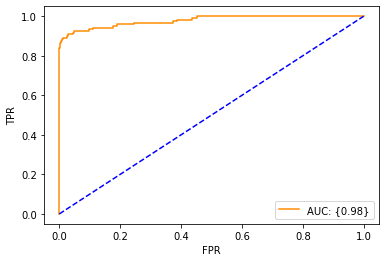

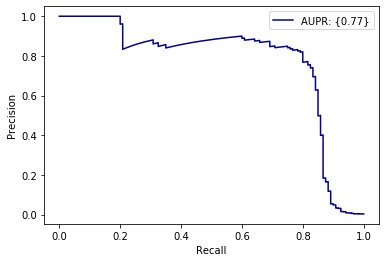

In [12]:
print('Baseline NLL loss: {}, precision@25: {}'.format(log_loss(test_y.values,y_pred), 
                                                                kprecision(test_y.values,y_pred,25)))
fpr, tpr, thresholds = roc_curve(test_y.values,y_pred)
plt.plot(fpr, tpr, color='darkorange',label = 'AUC: {%.2f}'%auc(fpr,tpr))
plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(test_y.values,y_pred)
aupr = auc(recall,precision)
plt.plot(recall, precision, color='darkblue', label='AUPR: {%.2f}'%aupr)
#plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Undersampling 

 16%|█▌        | 4/25 [00:03<00:20,  1.03it/s]/Users/ashwinbhola/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)

100%|██████████| 4/4 [46:46<00:00, 701.57s/it]


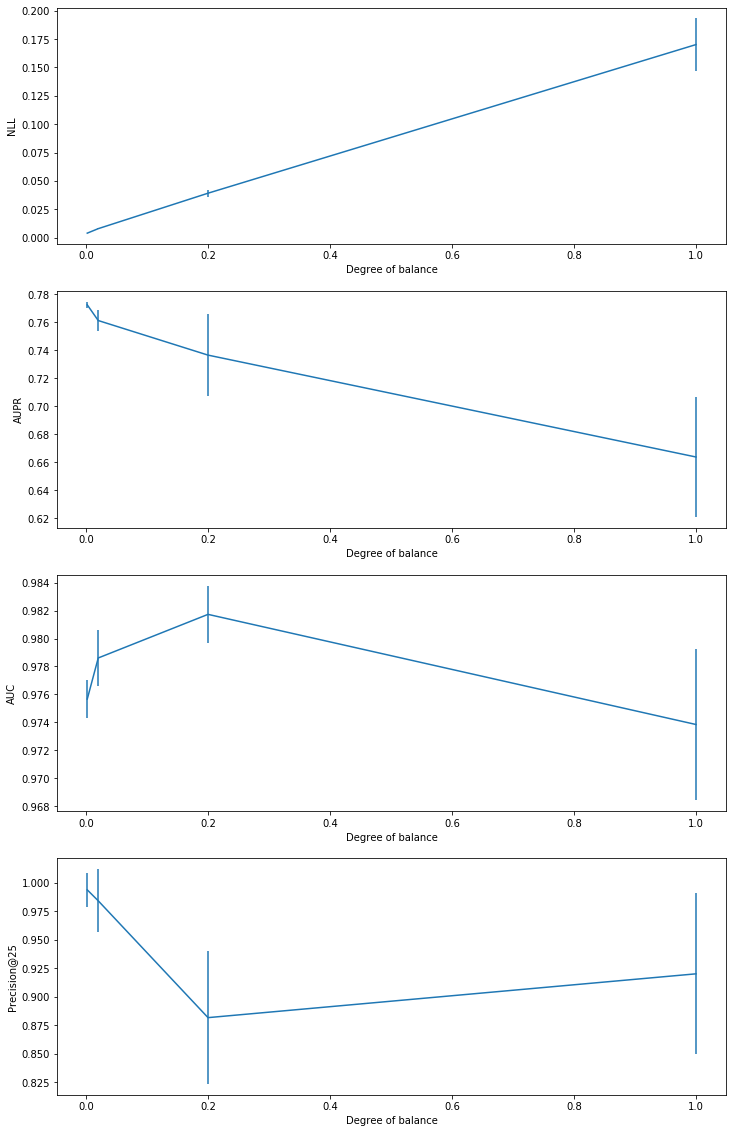

In [12]:
fractions = [1,0.2,0.02,0.002]
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
n_bootstrap = 25
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(n_bootstrap)):
        rus = RandomUnderSampler(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = rus.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        lr = LogisticRegression(solver='liblinear',max_iter=1000)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)


plt.show()



## Oversampling 

100%|██████████| 5/5 [1:12:23<00:00, 868.77s/it] 


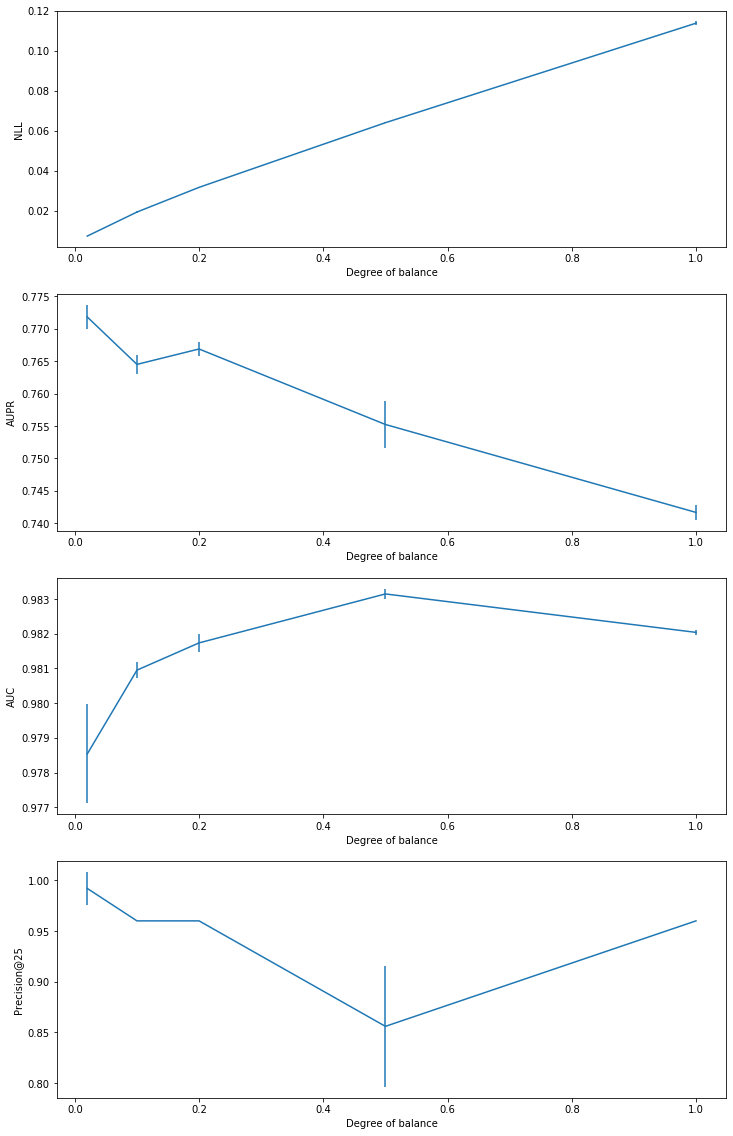

In [12]:
fractions = [1,0.5,0.2,0.1,0.02]
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
n_bootstrap = 5
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(n_bootstrap)):
        ros = RandomOverSampler(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = ros.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        lr = LogisticRegression(solver='liblinear',max_iter=1000)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)


plt.show()



100%|██████████| 5/5 [2:41:59<00:00, 1943.86s/it]


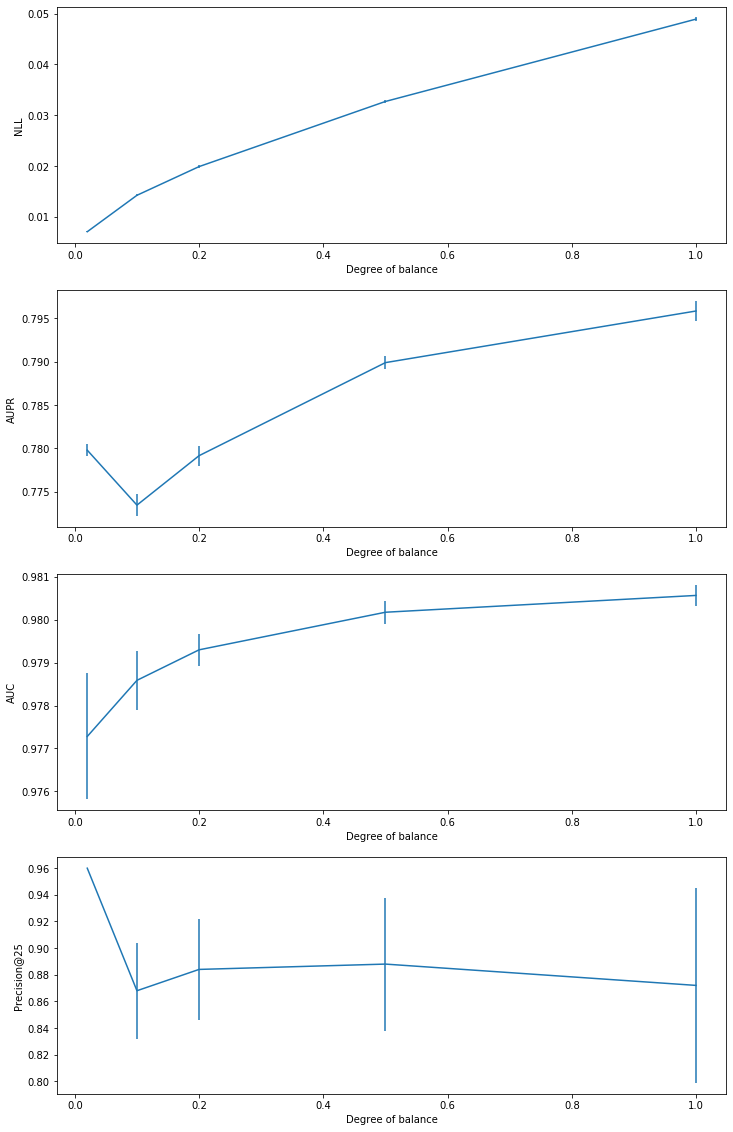

In [13]:
fractions = [1,0.5,0.2,0.1,0.02]
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
n_bootstrap = 10
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(n_bootstrap)):
        os = SMOTE(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = os.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        lr = LogisticRegression(solver='liblinear',max_iter=1000)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)


plt.show()



## Learning curve analysis

100%|██████████| 10/10 [18:26<00:00, 80.10s/it]


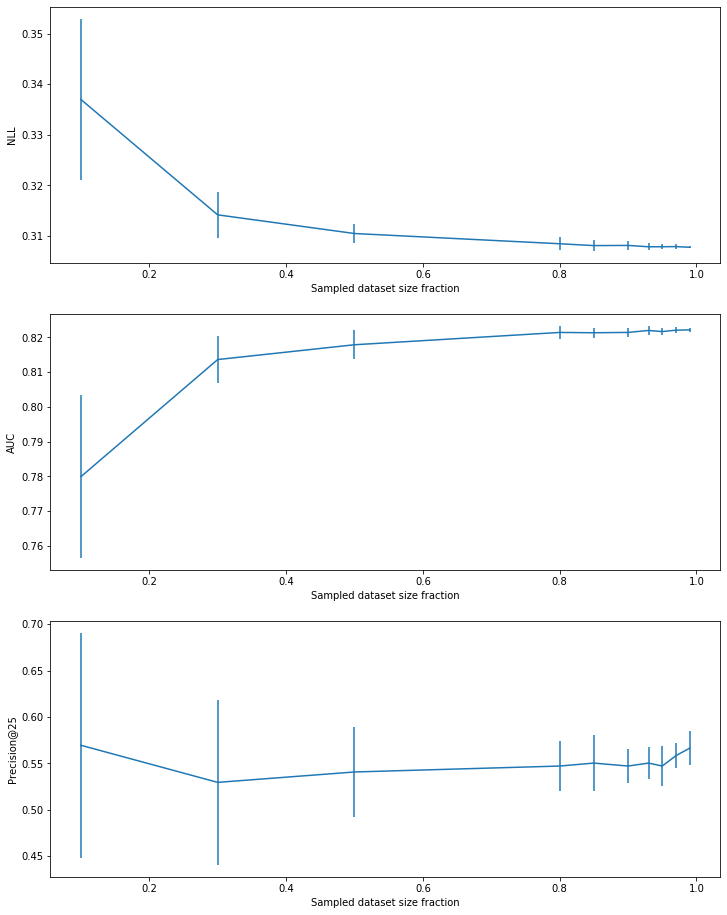

In [19]:
fractions = [0.99,0.97,0.95,0.93,0.9,0.85,0.8,0.5,0.3,0.1]
parameters = {'C':[10**k for k in range(-4,3)],'penalty':['l2','l1']}
n_bootstrap = 25
plt.figure(figsize=(12,16))
plt.subplot(211)
ax1 = plt.subplot(3, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Sampled dataset size fraction')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(3, 1, 2)
#ax2.set_xscale('log')
ax2.set_xlabel('Sampled dataset size fraction')
ax2.set_ylabel('AUC')
ax3 = plt.subplot(3, 1, 3)
#ax3.set_xscale('log')
ax3.set_xlabel('Sampled dataset size fraction')
ax3.set_ylabel('Precision@{}'.format(25))
mean_auc_us = []
std_auc_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    auc=[]
    precisions=[]
    log_losses=[]
    for r in range(n_bootstrap):
        train_x_resampled, _, train_y_resampled, _ = train_test_split(train_x, train_y, train_size=f)
        #print(train_y_resampled.value_counts())
        lr = LogisticRegression(solver='liblinear',max_iter=1000)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring='roc_auc').fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auc.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(precision(test_y.values,y_pred,25))
    mean_auc_us.append(np.mean(auc))
    std_auc_us.append(np.std(auc))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_auc_us, std_auc_us)
ax3.errorbar(fractions, mean_prec_us, std_prec_us)

plt.show()



100%|██████████| 4/4 [24:42<00:00, 370.61s/it]


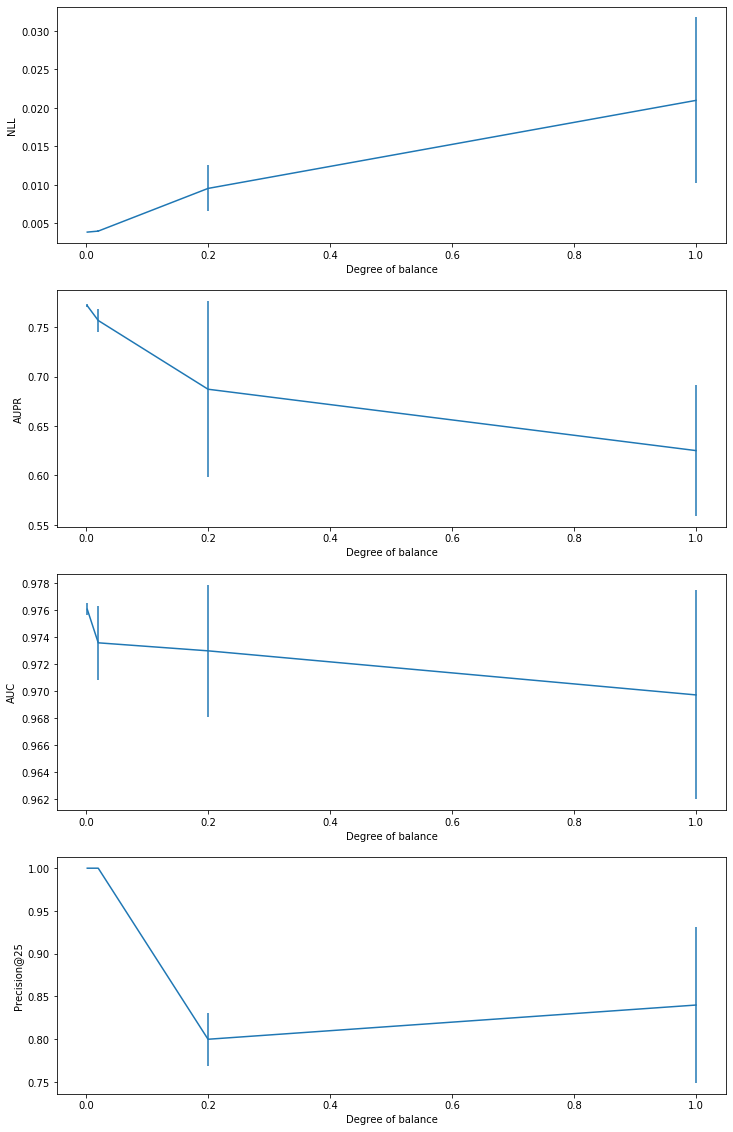

In [16]:
fractions = [1,0.2,0.02,0.002]
parameters = {'C':[10**k for k in range(-3,4)],'penalty':['l2','l1']}
n_bootstrap = 10
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

n_0 = train_y.size-train_y.sum()
n_1 = train_y.sum() 

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(1,n_bootstrap+1)):
        rus = RandomUnderSampler(sampling_strategy=f, random_state=r)
        train_x_resampled, train_y_resampled = rus.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        cw = {0:f*n_0/(1+f),1:1*n_1/(1+f)}
        lr = LogisticRegression(solver='liblinear',max_iter=1000,class_weight=cw)
        cv_estimator = GridSearchCV(lr, parameters, cv=3, return_train_score=True, scoring='roc_auc').fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)
plt.show()

